In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose, Resize
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Resize(64), Normalize(mean=(0.5,), std=(0.5,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



E:\Users\Asus\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
img, label = mnist[0]
print('Label: ', label)
print('Image Shape: ',img.shape)
print(img[:,10:15,10:15])

torch.min(img), torch.max(img)

Label:  5
Image Shape:  torch.Size([1, 64, 64])
tensor([[[-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])


(tensor(-1.), tensor(0.9843))

In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 64, 64])
tensor([8, 4, 5, 9, 6, 8, 6, 1, 8, 0, 6, 5, 2, 4, 5, 8, 6, 6, 6, 4, 6, 1, 1, 3,
        4, 0, 1, 7, 1, 2, 1, 3, 6, 8, 2, 1, 9, 5, 6, 6, 8, 6, 8, 3, 3, 5, 0, 3,
        7, 7, 5, 4, 9, 9, 8, 2, 2, 6, 6, 4, 8, 7, 3, 9, 8, 7, 3, 8, 0, 2, 3, 4,
        1, 4, 6, 8, 0, 2, 2, 9, 4, 2, 4, 1, 1, 6, 2, 0, 8, 3, 0, 8, 3, 3, 0, 5,
        7, 6, 1, 8])


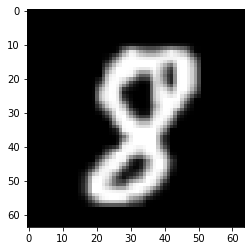

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

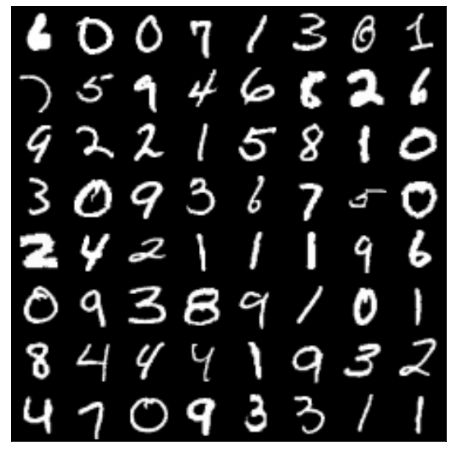

In [8]:
show_batch(data_loader)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
data_loader = DeviceDataLoader(data_loader, device)

# Discriminator Network

In [12]:
import torch.nn as nn

In [14]:
class SimpleDicriminatorBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=1, stride=1, padding=0, bias=False)#Output: 28 * 14 * 14
        
        #self.bn1 = nn.BatchNorm2d(28),
        #self.relu =nn.LeakyReLU(0.2, inplace=True)
        
        
    def forward(self, x):
        out = self.conv1(x)
        #out = self.bn1(out)
        #out = self.relu(out)
        #out = self.conv2(out)
        #return self.relu2(out) + x 
        return out

In [15]:
simple_discriminator = to_device(SimpleDicriminatorBlock(), device)

for images, labels in data_loader:
    out = simple_discriminator(images)
    print(out.shape)
    
    break
    
del simple_discriminator, images, labels
torch.cuda.empty_cache()

torch.Size([100, 32, 64, 64])


In [16]:
discriminator = nn.Sequential(
    # in: 1 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

# Generator Network

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 1 x 64 x 64
)

torch.Size([100, 1, 64, 64])


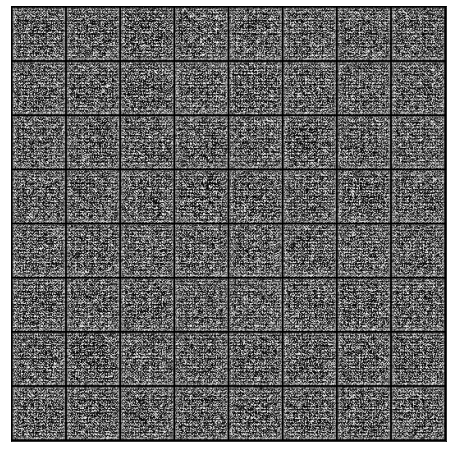

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

# Discriminator Training


In [22]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [23]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [24]:
from torchvision.utils import save_image

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


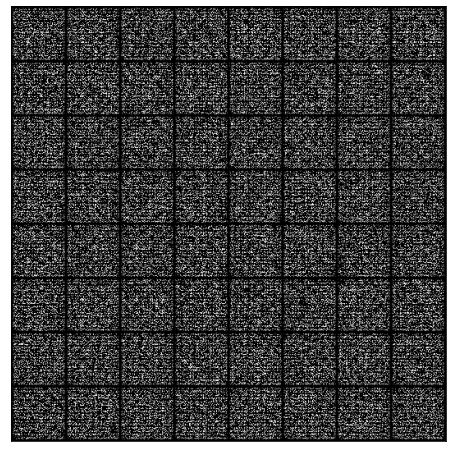

In [28]:
save_samples(0, fixed_latent)

In [29]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [30]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(data_loader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0002
epochs = 300

In [32]:
history = fit(epochs, lr)

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [1/300], loss_g: 2.5424, loss_d: 0.4041, real_score: 0.8474, fake_score: 0.1983
Saving generated-images-0001.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [2/300], loss_g: 3.0988, loss_d: 0.3007, real_score: 0.8762, fake_score: 0.1420
Saving generated-images-0002.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [3/300], loss_g: 4.0780, loss_d: 0.0426, real_score: 0.9713, fake_score: 0.0126
Saving generated-images-0003.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [4/300], loss_g: 2.5844, loss_d: 0.3661, real_score: 0.8603, fake_score: 0.1663
Saving generated-images-0004.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [5/300], loss_g: 4.7984, loss_d: 0.0246, real_score: 0.9945, fake_score: 0.0184
Saving generated-images-0005.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [6/300], loss_g: 4.1928, loss_d: 0.0218, real_score: 0.9879, fake_score: 0.0092
Saving generated-images-0006.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [7/300], loss_g: 5.6763, loss_d: 0.0193, real_score: 0.9919, fake_score: 0.0110
Saving generated-images-0007.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [8/300], loss_g: 2.5642, loss_d: 0.1003, real_score: 0.9323, fake_score: 0.0251
Saving generated-images-0008.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [9/300], loss_g: 5.2130, loss_d: 0.0387, real_score: 0.9811, fake_score: 0.0190
Saving generated-images-0009.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [10/300], loss_g: 6.2765, loss_d: 0.0051, real_score: 0.9966, fake_score: 0.0017
Saving generated-images-0010.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [11/300], loss_g: 4.9040, loss_d: 0.0172, real_score: 0.9858, fake_score: 0.0028
Saving generated-images-0011.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [12/300], loss_g: 6.1652, loss_d: 0.0070, real_score: 0.9967, fake_score: 0.0037
Saving generated-images-0012.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [13/300], loss_g: 5.5513, loss_d: 0.0244, real_score: 0.9873, fake_score: 0.0113
Saving generated-images-0013.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [14/300], loss_g: 6.7311, loss_d: 0.0081, real_score: 0.9935, fake_score: 0.0016
Saving generated-images-0014.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [15/300], loss_g: 6.2389, loss_d: 0.0028, real_score: 0.9985, fake_score: 0.0013
Saving generated-images-0015.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [16/300], loss_g: 6.1669, loss_d: 0.0224, real_score: 0.9812, fake_score: 0.0029
Saving generated-images-0016.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [17/300], loss_g: 1.0740, loss_d: 0.6135, real_score: 0.6085, fake_score: 0.0264
Saving generated-images-0017.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [18/300], loss_g: 6.6498, loss_d: 0.0044, real_score: 0.9976, fake_score: 0.0020
Saving generated-images-0018.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [19/300], loss_g: 2.0583, loss_d: 0.2880, real_score: 0.8250, fake_score: 0.0648
Saving generated-images-0019.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [20/300], loss_g: 6.1491, loss_d: 0.0270, real_score: 0.9816, fake_score: 0.0080
Saving generated-images-0020.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [21/300], loss_g: 6.2582, loss_d: 0.0054, real_score: 0.9967, fake_score: 0.0021
Saving generated-images-0021.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [22/300], loss_g: 7.3793, loss_d: 0.0249, real_score: 0.9992, fake_score: 0.0228
Saving generated-images-0022.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [23/300], loss_g: 2.1523, loss_d: 0.3616, real_score: 0.7372, fake_score: 0.0241
Saving generated-images-0023.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [24/300], loss_g: 3.0588, loss_d: 0.1128, real_score: 0.9567, fake_score: 0.0623
Saving generated-images-0024.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [25/300], loss_g: 3.6154, loss_d: 0.0486, real_score: 0.9840, fake_score: 0.0313
Saving generated-images-0025.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [26/300], loss_g: 3.2957, loss_d: 0.3281, real_score: 0.8469, fake_score: 0.1185
Saving generated-images-0026.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [27/300], loss_g: 6.8889, loss_d: 0.0329, real_score: 0.9988, fake_score: 0.0304
Saving generated-images-0027.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [28/300], loss_g: 6.8857, loss_d: 0.0038, real_score: 0.9973, fake_score: 0.0011
Saving generated-images-0028.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [29/300], loss_g: 6.5222, loss_d: 0.0093, real_score: 0.9961, fake_score: 0.0054
Saving generated-images-0029.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [30/300], loss_g: 8.4293, loss_d: 0.0011, real_score: 0.9996, fake_score: 0.0007
Saving generated-images-0030.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [31/300], loss_g: 8.3019, loss_d: 0.0005, real_score: 0.9999, fake_score: 0.0004
Saving generated-images-0031.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [32/300], loss_g: 16.0544, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0032.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [33/300], loss_g: 9.1626, loss_d: 0.0004, real_score: 0.9997, fake_score: 0.0002
Saving generated-images-0033.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [34/300], loss_g: 41.5887, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0034.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [35/300], loss_g: 40.6098, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0035.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [36/300], loss_g: 40.4963, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0036.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [37/300], loss_g: 40.4439, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0037.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [38/300], loss_g: 40.1944, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0038.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [39/300], loss_g: 40.0151, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0039.png


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [40/300], loss_g: 39.9328, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0040.png


  0%|          | 0/600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');